# Advanced DL and RL: Домашнее задание 3

In [133]:
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Часть первая: перенос стиля при помощи pix2pix
В этом задании мы будем реализовывать перенос стиля на paired данных. Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:


In [134]:
import tarfile

my_tar = tarfile.open('facades.tar')
my_tar.extractall('./')
my_tar.close()

In [135]:
def read_img(img_path):
    img = Image.open(img_path).resize((256, 128), Image.BICUBIC)
    img_tensor = transforms.ToTensor()(img)

    original_tensor = img_tensor[:,:,:128]
    mask_tensor = img_tensor[:,:,128:]
    
    return original_tensor, mask_tensor


def read_facade_folder(folder_path):
    img_paths = [
        os.path.join(folder_path, img_path)
        for img_path in os.listdir(folder_path)
        if img_path.endswith('.jpg')
    ]
    
    img_tensors = list(map(read_img, img_paths))
    return img_tensors


class FacadeDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path):
        self.img_tensors = read_facade_folder(folder_path)

    def __len__(self):
        return len(self.img_tensors)

    def __getitem__(self, index):
        return self.img_tensors[index]

In [136]:
train_dataset = FacadeDataset('facades/train')
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = FacadeDataset('facades/val')
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=True)

---

In [137]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        return torch.tanh(self.decoder(self.encoder(x)))

In [138]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(6, 12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1),
            nn.Flatten(),
            nn.BatchNorm1d(6144),
            nn.Linear(6144, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 1),
            nn.Sigmoid(),
        )

    def forward(self, original, generated):
        x = torch.cat([original, generated], dim=1)
        return self.net(x)

---

In [139]:
generator = Generator()
discriminator = Discriminator()

# loss
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

# Adam optimizer
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [140]:
n_epochs = 100
lambda_coef = 100

for i in range(n_epochs):
    discriminator_loss_history = []
    generator_loss_history = []

    for original, mask in train_loader:

        # Update Discriminator network
        discriminator.zero_grad()

        discriminator_result = discriminator(original, mask)
        discriminator_true = Variable(torch.ones(discriminator_result.size()))
        discriminator_real_loss = BCE_loss(discriminator_result, discriminator_true)

        generator_result = generator(mask)
        discriminator_result = discriminator(generator_result, mask)
        discriminator_true = Variable(torch.zeros(discriminator_result.size()))
        discriminator_fake_loss = BCE_loss(discriminator_result, discriminator_true)

        discriminator_train_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
        discriminator_loss_history.append(discriminator_train_loss.item())
        discriminator_train_loss.backward()
        discriminator_optimizer.step()

        # Update Generator network
        generator.zero_grad()

        generator_result = generator(mask)
        discriminator_result = discriminator(generator_result, mask)
        discriminator_true = Variable(torch.ones(discriminator_result.size()))

        generator_train_loss = BCE_loss(discriminator_result, discriminator_true)\
             + lambda_coef * L1_loss(generator_result, original)

        generator_loss_history.append(generator_train_loss.item())
        generator_train_loss.backward()
        generator_optimizer.step()

    print(f'Epoch: {i}, d_loss = {np.mean(discriminator_loss_history)}, g_loss = {np.mean(generator_loss_history)}')


Epoch: 0, d_loss = 0.5667685866355896, g_loss = 51.248353481292725
Epoch: 1, d_loss = 0.1608523279428482, g_loss = 48.10221290588379
Epoch: 2, d_loss = 0.051983228884637356, g_loss = 48.66279697418213
Epoch: 3, d_loss = 0.39876323472708464, g_loss = 47.89181184768677
Epoch: 4, d_loss = 0.08757706172764301, g_loss = 46.975425243377686
Epoch: 5, d_loss = 0.044612707337364554, g_loss = 44.89074754714966
Epoch: 6, d_loss = 0.07002938259392977, g_loss = 45.5865740776062
Epoch: 7, d_loss = 0.07347857882268727, g_loss = 44.12994909286499
Epoch: 8, d_loss = 0.012900296947918832, g_loss = 41.37988567352295
Epoch: 9, d_loss = 0.009752893587574363, g_loss = 41.095667362213135
Epoch: 10, d_loss = 0.04067582840798423, g_loss = 40.21592473983765
Epoch: 11, d_loss = 0.022324720077449456, g_loss = 39.01859426498413
Epoch: 12, d_loss = 0.004655563257983886, g_loss = 37.3975248336792
Epoch: 13, d_loss = 0.022200792984222062, g_loss = 36.6590256690979
Epoch: 14, d_loss = 0.008092802978353575, g_loss = 35

### Посмотрим что получилось

In [142]:
for x in val_loader:
    break

img, mask = x
result = generator(img)

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


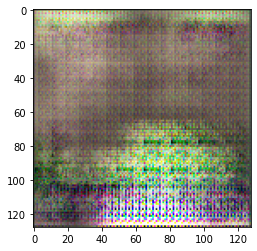

In [143]:
plt.imshow(result[0].detach().permute(1, 2, 0))

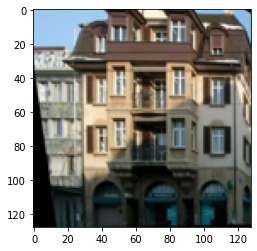

In [144]:
plt.imshow(img[0].permute(1, 2, 0))

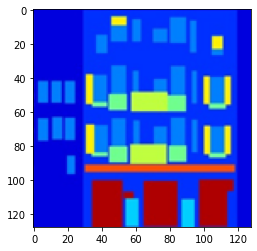

In [145]:
plt.imshow(mask[0].permute(1, 2, 0))

2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


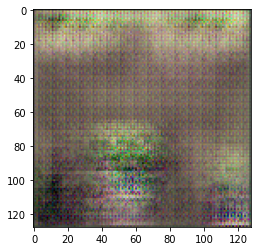

In [149]:
plt.imshow(result[2].detach().permute(1, 2, 0))

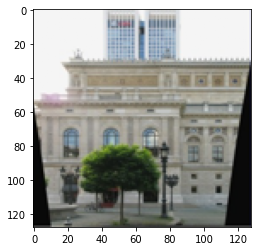

In [150]:
plt.imshow(img[2].permute(1, 2, 0))

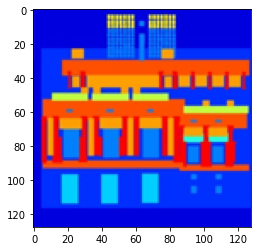

In [151]:
plt.imshow(mask[2].permute(1, 2, 0))